# Linear Neural Network - Logistic Regression (Linearly Non-Separable Data)

In this notebook, we cast the Logistic Regression technique for binary classification as a Linear Neural Network (LNN).

Using the LNN model we perform binary classification on a **linearly non-separable** data. Then, we visualize the decision boundary.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import make_circles

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

np.random.seed(43)

## Decision Boundary: Using Various Thresholds for a Class Probability

We define a function to show the decision boundaries at various thresholds of a class probability. Using the different estimates for a single class, we generate a contour plot. 

In [2]:
def decision_boundary_class_colored(clf, X):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points    
    y_pred_proba = clf.predict(X_new).reshape(x1.shape)

    y_pred = y_pred_proba
            
    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if(y_pred_proba[i][j] >= 0.5):
                y_pred[i][j] = 1
            else:
                y_pred[i][j] = 0
        
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.summer, alpha=0.9)

## Synthetic Dataset: Linearly Separable


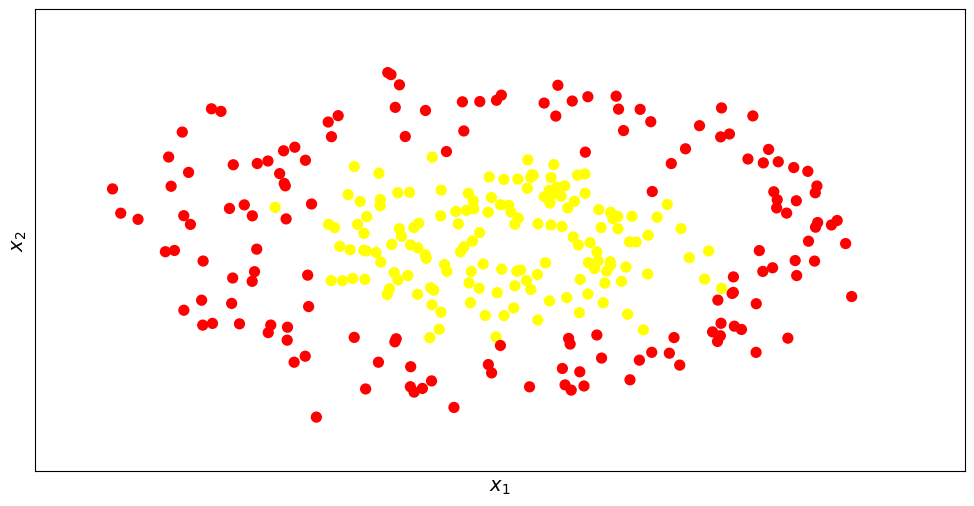

In [3]:
X, y = make_circles(300, factor=0.4, noise=0.15)

label = y

plt.figure(figsize=(12, 6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

#plt.title("Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.axis([-1.5, 1.5, -1.7, 1.7])
plt.xticks(())
plt.yticks(())
plt.show()

## Create a LNN Model

Using the Keras Dense layer we create a LNN model for Logistic Regression. **In a Dense layer, each neuron is connected to all inputs/neurons of the previous layer**.

The LNN model:
- has only one neuron.
- uses the logistic sigmoid function.

At first, we need to specify the shape of the input using the Input layer. The Input layer is used to instantiate a Keras tensor, which is a TensorFlow symbolic tensor object.
- We must set the "shape" parameter, which is a tuple (integers) indicating the dimension of the input vectors. In this demo, the input is a 2D vector, that's why we simply put [2, ] in the tuple. In image classification problems, an image input will be represented as a matrix, in which case we will need to specify the size of the matrix. For example, for a 28 x 28 image input matrix, the "shape" tuple will be [28, 28]. Note that we don't need to include the batch size.

Dense layer:
- kernel_initializer: we initialize the weights (also known as the kernel) with zero values. In logistic/softmax regression, initial zero weight values are ok. However, in nonlinear neural networks, such as Multi-layer Perceptron (MLPs), we must use small random values to initialize the weights. For that, we need to use sophisticated initializers, such as glorot or he.
- activation: we use logistic sigmoid


#### The commented-out dense layer with 4 neurons is used to show that by building a Multi-layer Perceptron (MLP), we can create a nonlinear decision boundary.

In [4]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise, memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = tf.keras.models.Sequential(name="LNN_Binary_Classifier")
model.add(tf.keras.layers.Input(shape=[2,]))
model.add(tf.keras.layers.Dense(units=4, kernel_initializer="he_normal", activation="relu"))
model.add(tf.keras.layers.Dense(units=1, kernel_initializer="zeros", activation="sigmoid"))

model.summary()

Model: "LNN_Binary_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
CPU times: user 61.7 ms, sys: 3.91 ms, total: 65.6 ms
Wall time: 21.4 ms


## Compile & Train the LNN Model


A Keras model automatically uses the **Backpropagation** algorithm to train an ANN. However, we need to specify an optimization algorithm. 

There are various advanced optimizers. For the LNN we will use the **Stochastic Gradient Descent (SGD)** optimizer. It requires us to set a suitable learning rate.  

We will use the mini-batch SGD. Thus we need to specify the batch size as well as the epochs.

In [5]:
'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.9)


'''
Compile the model
'''
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64

'''
Train the model
'''
history = model.fit(X, y, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1)

Epoch 1/50
5/5 [==============================] - 0s 901us/step - loss: 0.6744 - accuracy: 0.5467
Epoch 2/50
5/5 [==============================] - 0s 768us/step - loss: 0.6423 - accuracy: 0.5967
Epoch 3/50
5/5 [==============================] - 0s 768us/step - loss: 0.6164 - accuracy: 0.6833
Epoch 4/50
5/5 [==============================] - 0s 892us/step - loss: 0.5929 - accuracy: 0.6967
Epoch 5/50
5/5 [==============================] - 0s 713us/step - loss: 0.5603 - accuracy: 0.8600
Epoch 6/50
5/5 [==============================] - 0s 521us/step - loss: 0.5259 - accuracy: 0.8833
Epoch 7/50
5/5 [==============================] - 0s 547us/step - loss: 0.4894 - accuracy: 0.9000
Epoch 8/50
5/5 [==============================] - 0s 516us/step - loss: 0.4533 - accuracy: 0.9233
Epoch 9/50
5/5 [==============================] - 0s 551us/step - loss: 0.4165 - accuracy: 0.9200
Epoch 10/50
5/5 [==============================] - 0s 475us/step - loss: 0.3864 - accuracy: 0.9400
Epoch 11/50
5/5 [==

2024-09-18 20:45:14.429548: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 0s 635us/step - loss: 0.2337 - accuracy: 0.9467
Epoch 19/50
5/5 [==============================] - 0s 465us/step - loss: 0.2242 - accuracy: 0.9467
Epoch 20/50
5/5 [==============================] - 0s 448us/step - loss: 0.2167 - accuracy: 0.9500
Epoch 21/50
5/5 [==============================] - 0s 419us/step - loss: 0.2068 - accuracy: 0.9500
Epoch 22/50
5/5 [==============================] - 0s 457us/step - loss: 0.2054 - accuracy: 0.9500
Epoch 23/50
5/5 [==============================] - 0s 466us/step - loss: 0.1940 - accuracy: 0.9500
Epoch 24/50
5/5 [==============================] - 0s 528us/step - loss: 0.1888 - accuracy: 0.9500
Epoch 25/50
5/5 [==============================] - 0s 485us/step - loss: 0.1821 - accuracy: 0.9600
Epoch 26/50
5/5 [==============================] - 0s 435us/step - loss: 0.1768 - accuracy: 0.9600
Epoch 27/50
5/5 [==============================] - 0s 423us/step - loss: 0.1754 - accuracy: 0.9500
Epoch 28/50
5/5 [=====

## Evaluate the LNN Model

In [6]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X, y, verbose=0))


y_predicted_proba = model.predict(X)

print(len(y_predicted_proba))

y_predicted = y_predicted_proba

for i in range(len(y_predicted)):
    if(y_predicted_proba[i] >= 0.5):
        y_predicted[i] = 1
    else:
        y_predicted[i] = 0


y_predicted = y_predicted.ravel()
accuracy = np.mean(y_predicted == y)
print("\nAccuracy: ", accuracy)



print("\nConfusion Matrix:")
print(confusion_matrix(y, y_predicted))

print("\nClassification Report:")
print(classification_report(y, y_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [0.11959058046340942, 0.9599999785423279]
10/10 [==============================] - 0s 315us/step
300

Accuracy:  0.96

Confusion Matrix:
[[141   9]
 [  3 147]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       150
           1       0.94      0.98      0.96       150

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



## Plot The Decision Boundary

313/313 [==============================] - 0s 190us/step


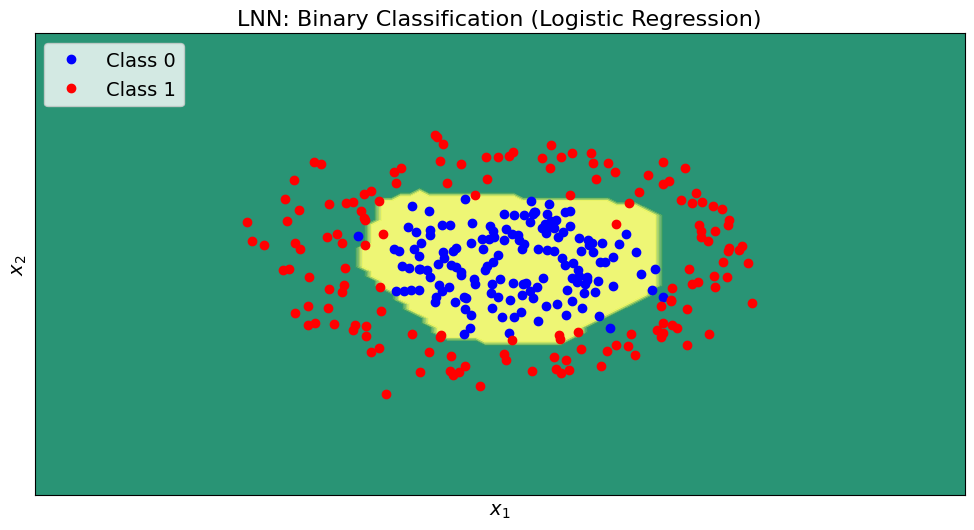

In [7]:
plt.figure(figsize=(12, 6))    

decision_boundary_class_colored(model, X)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")

plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("LNN: Binary Classification (Logistic Regression)", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()